### 3.1 Anatomy of a neural network

神经网络主要包括了以下四方面：
- layers, which are combined into a network
- input data & targets(labels)
- loss function
- optimizer

#### 3.1.1 Layers: the building blocks of deep learning

Layers是neural networks的基本结构，其是一个数据处理模块，将输入张量转换为输出张量。大多数层是有状态的，即包含trainable parameters or weights，weights可以被视为学习到的knowledge。

不同的数据处理需要用到不同的layers，如简单的(samples, features)的2D tensor可以使用全连接层，即keras中的Dense处理；序列数据(samples, timesteps, features)的3D tensor需要用到keras中的LSTM层等recurrent layer处理；图像数据的4D tensor则需要用到卷积层，即keras中的Conv2D处理。

Layers在组装过程中需要注意到layer compatibility，即每一层接受的shape应该和上一层输出的shape相同，这一点keras自动推导即可保证。如下面的model，第二层layer并未指定input_shape，keras框架也知道其input_shape应该是(samples, 32)。

In [1]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(32, input_shape=(784,)))
model.add(layers.Dense(32))

C:\Users\10750\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 3.1.2 Models: networks of layers

深度学习模型即由layers构成的**有向无环图**，一般我们见到的最简单的网络拓扑结构就是layers的线性堆叠，但仍存在其他类型的网络拓扑结构，如：
- two-branch network
- multihead network
- inception blocks

网络的结构定义出的是hypothesis space，而要选择合适的结构is more an art than a science。

### 3.1.3 Loss functions and optimizers: keys to configuring the learning process

loss functions和optimizers作为模型在compile过程的参数，在模型训练过程中有着至关重要的作用。

有多个输出的神经网络可能对应了多个loss functions，但由于梯度下降过程必须基于**单个标量loss值**，因此多个loss要取平均或其他处理为最终loss的值。

loss function的选取对于模型的训练real real重要！大多数新问题需要针对性的设计loss，但对于一些简单的问题，也有着相应指导原则：如对于二分类问题可以用binary crossentropy作为loss；对于多分类问题可以用categorical crossentropy作为loss；对于序列问题可以用CTC(connectionist temporal classification)作为loss，等等。

### 3.2 Keras

keras支持Tensorflow、CNTK、Theano三个backend engine，并且可以在三个后端上无缝切换。

keras的工作流程如下：
1. 定义训练数据：输入train_x和train_y；
2. 定义network，将输入映射到target；
3. compile学习过程：选择loss，optimizer和metrics；
4. 调用fit方法在训练数据上迭代；

keras支持两种定义模型的方法：一是使用Sequential类，其仅适用于层的线性堆叠；二是使用functional API，用于层组成的有向无环图，可以构建任意形式的架构。

In [3]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(32, input_shape=(784,), activation='relu'))
network.add(layers.Dense(10, activation='softmax'))

In [4]:
input_tensor = layers.Input(shape=(784,))
x = layers.Dense(32, activation='relu')(input_tensor)
output_tensor = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=input_tensor, outputs=output_tensor)

### 3.4 Classifying movie reviews: a binary classification example



In [5]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 10s 1us/step


In [10]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = ''.join(
    [reverse_word_index.get(i-3, '?') for i in train_data[0]])

1646592/1641221 [==============================] - 3s 2us/step


预处理数据时，需要对与train_data进行预处理。可以看到这里的原始数据是整数列表的格式，且列表长度不一。我们可以采取以下两种方法将数据转换为张量：
- 填充列表使其具有相同的长度，再将其转换为(samples, word_indices)的shape。
- 对列表进行one-hot编码，维数等于10000，即在对应index上的word为1。
以下采取one-hot编码的方式将数据向量化：

In [12]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [15]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [16]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

在选择compile的参数时，如果需要更specific的参数，可以传入优化器实例作为optimizer参数或者函数对象作为loss/metrics，如下例所示：


In [18]:
from keras import optimizers
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

在训练过程中，我们一般还要将每次train出来的模型在验证集上做validation，下面将训练集前10000个samples作为验证集：

In [19]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

验证数据传入需要在fit过程中将x_val与y_val传入给validation_data参数

In [20]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 26s 2ms/step - loss: 0.5084 - binary_accuracy: 0.7813 - val_loss: 0.3797 - val_binary_accuracy: 0.86846s - loss: 0.5697 - binary
Epoch 2/20
15000/15000 [==============================] - 4s 279us/step - loss: 0.3004 - binary_accuracy: 0.9047 - val_loss: 0.3004 - val_binary_accuracy: 0.8897
Epoch 3/20
15000/15000 [==============================] - 4s 262us/step - loss: 0.2179 - binary_accuracy: 0.9285 - val_loss: 0.3085 - val_binary_accuracy: 0.8711: 1s - loss: 0.2207 - binary_accuracy: 0. - ETA: 1s - loss: 0.2216 - binary_accuracy:  - ETA: 0s - loss: 0.2203 - binary_accura
Epoch 4/20
15000/15000 [==============================] - 4s 254us/step - loss: 0.1750 - binary_accuracy: 0.9437 - val_loss: 0.2840 - val_binary_accuracy: 0.8832
Epoch 5/20
15000/15000 [==============================] - 4s 262us/step - loss: 0.1427 - binary_accuracy: 0.9543 - val_loss: 0.2841 - val_binary_accur

注意，调用model.fit()返回了一个History对象。这个对象有一个成员history，它是一个字典，包含训练过程中的所有数据。

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

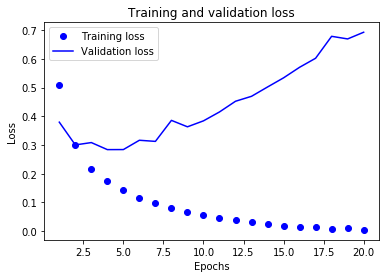

In [22]:
import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

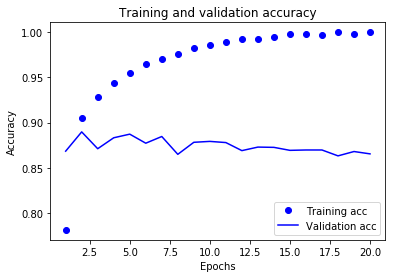

In [24]:
plt.clf()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
results = model.evaluate(x_test, y_test)

25000/25000 [==============================] - 12s 468us/step


In [28]:
model.predict(x_test)

array([[0.00549961],
       [0.9999999 ],
       [0.91050684],
       ...,
       [0.00161517],
       [0.00572949],
       [0.4845214 ]], dtype=float32)

model的predict方法可以用于实践，给出模型对一个或一组输入的预测。

### 3.5 Classifying newswires: a multiclass classification example

路透社数据集reuters中的新闻包含了46个互斥的主题，每个sample被分到一个类别，因此准确的说是一个single-label, multiclass classification的问题。

In [33]:
from keras.datasets import reuters

(train_data, train_lable), (test_data, test_lable) = reuters.load_data(num_words=10000)

In [34]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

对于label的向量化，我们可以将其转化为one-hot编码，也叫categorical encoding分类编码。Keras中的内置方法可以实现这个操作：

In [35]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_label)
one_hot_test_labels = to_categorical(test_lable)

In [37]:
one_hot_train_labels.shape

(8982, 46)

In [38]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [39]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [41]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val,y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 353us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 2s 207us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 2s 208us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 2s 188us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 2s 189us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810ss: 0.7098 - acc: 0.
Epoch 6/20
7982/7982 [==============================] - 2s 211us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 2s 213us/step - loss: 0.4581 - acc: 0.9048 - val_loss: 0.908

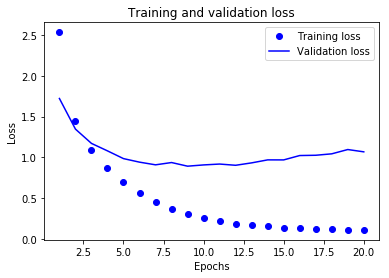

In [42]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

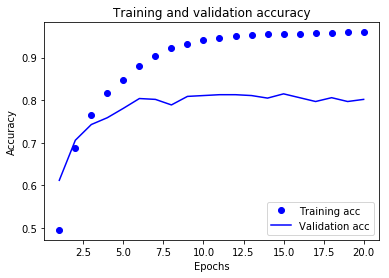

In [43]:
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [44]:
results = model.evaluate(x_test, one_hot_test_labels)

2246/2246 [==============================] - 1s 370us/step


In [45]:
results

[1.2092603144641445, 0.778717720444884]

### 3.6 Predicting house prices: a regression example

本任务将预测20世纪70年代中期波士顿郊区房屋价格的中位数，数据特征包括犯罪率、当地房产税率等等。训练样本数目为404， 测试样本数目为102个。

需要注意的是，每个feature的取值范围各不相同，有的是比例，范围是0-1，有的是1-12，有的是0-100，等等。

In [46]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 1s 20us/step
